In [1]:
%load_ext autoreload
%autoreload 2

# Step loading data

In [2]:
import pandas as pd
import numpy as np
from openproblems.tasks.regulatory_effect_prediction import datasets
adata = datasets.scicar_mouse_kidney(test=False)

... storing 'source' as categorical
... storing 'replicate' as categorical
... storing 'experiment' as categorical
... storing 'cell_name' as categorical
... storing 'gene_type' as categorical
... storing 'gene_short_name' as categorical


In [3]:
adata.uns['mode2_var_chr'].shape, adata.uns['mode2_var'].shape

((249448,), (249448,))

In [4]:
adata.shape, adata.obsm['mode2'].shape

((11296, 29013), (11296, 249448))

## Copy of utility functions

In [5]:
from openproblems.patch import patch_datacache
import numpy as np
import pandas as pd
import scanpy as sc
import warnings

def _chrom_limit(x, tss_size=2e5):
    """Extend TSS to upstream and downstream intervals.

    Parameters
    ----------
    x : pd.Series
        a pd.Series containing [start, end, direction]
        where start and end are ints and direction is {'+', '-'}.
    tss_size: int
        a int that defines the upstream and downstream regions around TSS
    """
    y = x.values
    gene_direction = y[-1]
    gene_start = y[-3]
    gene_end = y[-2]
    if gene_direction == "+":
        return [gene_start - tss_size // 2, gene_start + tss_size // 2]
    else:
        return [gene_end - tss_size // 2, gene_end + tss_size // 2]


def _get_annotation(adata, retries=3):
    """Insert meta data into adata.obs."""
    from pyensembl import EnsemblRelease

    data = EnsemblRelease(
        adata.uns["release"],
        adata.uns["species"],
    )
    for _ in range(retries):
        try:
            with patch_datacache():
                data.download(overwrite=False)
                data.index(overwrite=False)
            break
        except TimeoutError:
            pass

    # get ensemble gene coordinate
    genes = []
    for i in adata.var.index.map(lambda x: x.split(".")[0]):
        try:
            with warnings.catch_warnings():
                warnings.filterwarnings(
                    action="ignore", message="No results found for query"
                )
                gene = data.gene_by_id(i)
            genes.append(
                [
                    "chr%s" % gene.contig,
                    gene.start,
                    gene.end,
                    gene.strand,
                ]
            )
        except ValueError:
            try:
                with warnings.catch_warnings():
                    warnings.filterwarnings(
                        action="ignore", message="No results found for query"
                    )
                    i = data.gene_ids_of_gene_name(i)[0]
                gene = data.gene_by_id(i)
                genes.append(
                    [
                        "chr%s" % gene.contig,
                        gene.start,
                        gene.end,
                        gene.strand,
                    ]
                )
            except (IndexError, ValueError) as e:
                print(e)
                genes.append([np.nan, np.nan, np.nan, np.nan])
    old_col = adata.var.columns.values
    adata.var = pd.concat(
        [adata.var, pd.DataFrame(genes, index=adata.var_names)], axis=1
    )
    adata.var.columns = np.hstack(
        [old_col, np.array(["chr", "start", "end", "strand"])]
    )


def _filter_mitochondrial(adata):
    if adata.uns["species"] in ["mus_musculus", "homo_sapiens"]:
        adata.var["mt"] = adata.var.gene_short_name.str.lower().str.startswith(
            "mt-"
        )  # annotate the group of mitochondrial genes as 'mt'
        sc.pp.calculate_qc_metrics(
            adata, qc_vars=["mt"], percent_top=None, log1p=False, inplace=True
        )

        adata_filter = adata[adata.obs.pct_counts_mt <= 10]
        if adata_filter.shape[0] > 100:
            adata = adata_filter.copy()
    return adata


def _filter_n_genes_max(adata):
    adata_filter = adata[adata.obs.n_genes_by_counts <= 2000]
    if adata_filter.shape[0] > 100:
        adata = adata_filter.copy()
    return adata


def _filter_n_genes_min(adata):
    adata_filter = adata.copy()
    sc.pp.filter_cells(adata_filter, min_genes=200)
    if adata_filter.shape[0] > 100:
        adata = adata_filter
    return adata


def _filter_n_cells(adata):
    adata_filter = adata.copy()
    sc.pp.filter_genes(adata_filter, min_cells=5)
    if adata_filter.shape[1] > 100:
        adata = adata_filter
    return adata


def _filter_has_chr(adata):
    adata_filter = adata[:, ~pd.isnull(adata.var.loc[:, "chr"])].copy()
    if adata_filter.shape[1] > 100:
        adata = adata_filter
    return adata

## Get gene coordinates

In [6]:
_get_annotation(adata)

No results found for query:

            SELECT distinct gene_id
            FROM gene
            WHERE gene_name = ?
        
with parameters: ['ENSMUSG00000097109']
No results found for query:

            SELECT distinct gene_id
            FROM gene
            WHERE gene_name = ?
        
with parameters: ['ENSMUSG00000100371']
No results found for query:

            SELECT distinct gene_id
            FROM gene
            WHERE gene_name = ?
        
with parameters: ['ENSMUSG00000097131']
No results found for query:

            SELECT distinct gene_id
            FROM gene
            WHERE gene_name = ?
        
with parameters: ['ENSMUSG00000097285']
No results found for query:

            SELECT distinct gene_id
            FROM gene
            WHERE gene_name = ?
        
with parameters: ['ENSMUSG00000096941']
No results found for query:

            SELECT distinct gene_id
            FROM gene
            WHERE gene_name = ?
        
with parameters: ['ENSMUSG000001

No results found for query:

            SELECT distinct gene_id
            FROM gene
            WHERE gene_name = ?
        
with parameters: ['ENSMUSG00000097364']
No results found for query:

            SELECT distinct gene_id
            FROM gene
            WHERE gene_name = ?
        
with parameters: ['ENSMUSG00000084894']
No results found for query:

            SELECT distinct gene_id
            FROM gene
            WHERE gene_name = ?
        
with parameters: ['ENSMUSG00000097206']
No results found for query:

            SELECT distinct gene_id
            FROM gene
            WHERE gene_name = ?
        
with parameters: ['ENSMUSG00000097138']
No results found for query:

            SELECT distinct gene_id
            FROM gene
            WHERE gene_name = ?
        
with parameters: ['ENSMUSG00000097598']
No results found for query:

            SELECT distinct gene_id
            FROM gene
            WHERE gene_name = ?
        
with parameters: ['ENSMUSG000001

No results found for query:

            SELECT distinct gene_id
            FROM gene
            WHERE gene_name = ?
        
with parameters: ['ENSMUSG00000097526']
No results found for query:

            SELECT distinct gene_id
            FROM gene
            WHERE gene_name = ?
        
with parameters: ['ENSMUSG00000097353']
No results found for query:

            SELECT distinct gene_id
            FROM gene
            WHERE gene_name = ?
        
with parameters: ['ENSMUSG00000097173']
No results found for query:

            SELECT distinct gene_id
            FROM gene
            WHERE gene_name = ?
        
with parameters: ['ENSMUSG00000101716']
No results found for query:

            SELECT distinct gene_id
            FROM gene
            WHERE gene_name = ?
        
with parameters: ['ENSMUSG00000097457']
No results found for query:

            SELECT distinct gene_id
            FROM gene
            WHERE gene_name = ?
        
with parameters: ['ENSMUSG000000

No results found for query:

            SELECT distinct gene_id
            FROM gene
            WHERE gene_name = ?
        
with parameters: ['ENSMUSG00000097344']
No results found for query:

            SELECT distinct gene_id
            FROM gene
            WHERE gene_name = ?
        
with parameters: ['ENSMUSG00000097465']
No results found for query:

            SELECT distinct gene_id
            FROM gene
            WHERE gene_name = ?
        
with parameters: ['ENSMUSG00000091562']
No results found for query:

            SELECT distinct gene_id
            FROM gene
            WHERE gene_name = ?
        
with parameters: ['ENSMUSG00000103648']
No results found for query:

            SELECT distinct gene_id
            FROM gene
            WHERE gene_name = ?
        
with parameters: ['ENSMUSG00000097757']
No results found for query:

            SELECT distinct gene_id
            FROM gene
            WHERE gene_name = ?
        
with parameters: ['ENSMUSG000000

No results found for query:

            SELECT distinct gene_id
            FROM gene
            WHERE gene_name = ?
        
with parameters: ['ENSMUSG00000097444']
No results found for query:

            SELECT distinct gene_id
            FROM gene
            WHERE gene_name = ?
        
with parameters: ['ENSMUSG00000097468']
No results found for query:

            SELECT distinct gene_id
            FROM gene
            WHERE gene_name = ?
        
with parameters: ['ENSMUSG00000097197']
No results found for query:

            SELECT distinct gene_id
            FROM gene
            WHERE gene_name = ?
        
with parameters: ['ENSMUSG00000096946']
No results found for query:

            SELECT distinct gene_id
            FROM gene
            WHERE gene_name = ?
        
with parameters: ['ENSMUSG00000096919']
No results found for query:

            SELECT distinct gene_id
            FROM gene
            WHERE gene_name = ?
        
with parameters: ['ENSMUSG000000

In [7]:
adata.var.head()

,gene_type,gene_short_name,n_counts,chr,start,end,strand
gene_id,,,,,,,
ENSMUSG00000051951.5,protein_coding,Xkr4,134.0,chr1,3205901.0,3671498.0,-
ENSMUSG00000104017.1,TEC,Gm37363,1.0,chr1,3375556.0,3377788.0,-
ENSMUSG00000089699.1,antisense,Gm1992,9.0,chr1,3466587.0,3513553.0,+
ENSMUSG00000102331.1,sense_intronic,Gm19938,2.0,chr1,3647309.0,3658904.0,-
ENSMUSG00000102343.1,lincRNA,Gm37381,76.0,chr1,3905739.0,3986215.0,-


In [8]:
adata.shape, adata.obsm['mode2'].shape

((11296, 29013), (11296, 249448))

In [9]:
# basic quality control
adata = _filter_has_chr(adata)
adata = _filter_mitochondrial(adata)
adata = _filter_n_genes_max(adata)
adata = _filter_n_genes_min(adata)
adata = _filter_n_cells(adata)

In [10]:
adata.shape, adata.obsm['mode2'].shape

((7704, 19301), (7704, 249448))

## Normalize 

In [11]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

# (Joint) Feature selection 

* currently selected by top 2000 variable genes

In [12]:
if 2000 <= adata.shape[1]:
    sc.pp.highly_variable_genes(adata, n_top_genes=2000)
    adata = adata[:, adata.var.highly_variable].copy()

In [312]:
# sc.pp.regress_out(adata, ["total_counts", "pct_counts_mt"])
# sc.pp.scale(adata, max_value=10)

In [13]:
# generate peak to gene weight matrix
# remove genes without annotation
adata = adata[
    :, adata.var.loc[:, "chr"].isin(np.unique(adata.uns["mode2_var_chr"]))
].copy()

In [14]:
adata.shape, adata.obsm['mode2'].shape

((7704, 1999), (7704, 249448))

# Regulatory effect score

In [15]:
# filter atac-seq matrix
sel = np.isin(adata.uns["mode2_var_chr"], adata.var.loc[:, "chr"].unique())
adata.uns["mode2_var"] = adata.uns["mode2_var"][sel]
adata.uns["mode2_var_chr"] = adata.uns["mode2_var_chr"][sel]
adata.uns["mode2_var_start"] = adata.uns["mode2_var_start"][sel]
adata.uns["mode2_var_end"] = adata.uns["mode2_var_end"][sel]
adata.obsm["mode2"] = adata.obsm["mode2"][:, sel]

In [16]:
adata.shape, adata.obsm['mode2'].shape

((7704, 1999), (7704, 249220))

In [17]:
adata.var.loc[:, ["start", "end", "strand"]].head()

,start,end,strand
gene_id,,,
ENSMUSG00000025900.12,3999557.0,4409241.0,-
ENSMUSG00000098104.1,4687934.0,4689403.0,-
ENSMUSG00000025909.16,8361475.0,9299878.0,-
ENSMUSG00000079671.8,9560832.0,9631175.0,-
ENSMUSG00000099032.2,9960163.0,9967932.0,-


In [18]:
# extend tss upstream and downstream
extend_tss = adata.var.loc[:, ["start", "end", "strand"]].apply(
    _chrom_limit, axis=1
)
extend_tss.shape

(1999,)

In [19]:
if isinstance(extend_tss, pd.DataFrame):
    # should be a series
    extend_tss = extend_tss.iloc[:, 0]

extend_tss = pd.concat(
    [
        adata.var.loc[:, "chr"],
        extend_tss.map(lambda x: x[0]).astype("int32"),
        extend_tss.map(lambda x: x[1]).astype("int32"),
        pd.Series(np.arange(adata.shape[1]), index=adata.var_names),
    ],
    axis=1,
)

In [20]:
(extend_tss.iloc[:, 1]>0).sum(), (extend_tss.iloc[:, 2]>0).sum()

(1999, 1999)

In [21]:
# peak summits
peaks = pd.DataFrame(
    {
        "chr": adata.uns["mode2_var_chr"],
        "start": adata.uns["mode2_var_start"].astype("int32"),
        "end": adata.uns["mode2_var_end"].astype("int32"),
    }
)
summits = pd.concat(
    [
        peaks.iloc[:, 0],
        peaks.iloc[:, [1, 2]].mean(axis=1).astype("int32"),
        (peaks.iloc[:, [1, 2]].mean(axis=1) + 1).astype("int32"),
        pd.Series(np.arange(peaks.shape[0])),
    ],
    axis=1,
)

In [22]:
peaks.shape, summits.shape

((249220, 3), (249220, 4))

## Intersection between peak and TSS(+/- 100kb)

In [23]:
import pybedtools

# overlap TSS bins with peaks
x = pybedtools.BedTool.from_dataframe(summits)
y = pybedtools.BedTool.from_dataframe(extend_tss)

In [24]:
#tss_to_peaks = y.intersect(x, wb=True, wa=True, loj=False).to_dataframe()
tss_to_peaks = x.intersect(y, wb=True, wa=True, loj=True)

/Users/qq06/anaconda3/envs/openproblem/lib/python3.8/subprocess.py:849: RuntimeWarning: line buffering (buffering=1) isn't supported in binary mode, the default buffer size will be used
  self.stderr = io.open(errread, 'rb', bufsize)


In [25]:
tss_to_peaks = tss_to_peaks.to_dataframe(disable_auto_names=True, header=0,
                                         names=["peak_chr", 
                                                 "peak_summit_left",
                                                 "peak_summit_right", 
                                                 "peak_index", 
                                                 "gene_chr", 
                                                 "gene_bin_start", 
                                                 "gene_bin_end", 
                                                 "gene_index"])
print(tss_to_peaks.shape)

(267204, 8)


In [26]:
tss_to_peaks

,peak_chr,peak_summit_left,peak_summit_right,peak_index,gene_chr,gene_bin_start,gene_bin_end,gene_index
0,chr1,3050873,3050874,1,.,-1,-1,.
1,chr1,3059202,3059203,2,.,-1,-1,.
2,chr1,3073153,3073154,3,.,-1,-1,.
3,chr1,3101916,3101917,4,.,-1,-1,.
4,chr1,3187755,3187756,5,.,-1,-1,.
...,...,...,...,...,...,...,...,...
267199,chrY,90805179,90805180,249215,.,-1,-1,.
267200,chrY,90808869,90808870,249216,.,-1,-1,.
267201,chrY,90811963,90811964,249217,.,-1,-1,.
267202,chrY,90819728,90819729,249218,.,-1,-1,.


In [27]:
# remove non-overlapped TSS and peaks
tss_to_peaks = tss_to_peaks.loc[
    (tss_to_peaks.gene_chr != ".") | (tss_to_peaks.gene_index != "."), :
]

In [28]:
tss_to_peaks

,peak_chr,peak_summit_left,peak_summit_right,peak_index,gene_chr,gene_bin_start,gene_bin_end,gene_index
65,chr1,4322350,4322351,66,chr1,4309241,4509241,0
66,chr1,4360414,4360415,67,chr1,4309241,4509241,0
67,chr1,4364929,4364930,68,chr1,4309241,4509241,0
68,chr1,4404195,4404196,69,chr1,4309241,4509241,0
69,chr1,4409314,4409315,70,chr1,4309241,4509241,0
...,...,...,...,...,...,...,...,...
266451,chrY,1286530,1286531,248467,chrY,1177582,1377582,1998
266452,chrY,1308477,1308478,248468,chrY,1177582,1377582,1998
266453,chrY,1352663,1352664,248469,chrY,1177582,1377582,1998
266454,chrY,1364910,1364911,248470,chrY,1177582,1377582,1998


In [29]:
(tss_to_peaks.iloc[:, 1] >0).sum(), (tss_to_peaks.iloc[:, 2] >0).sum()

(70636, 70636)

In [30]:
tss_to_peaks.shape, (tss_to_peaks.iloc[:, 5] >0).sum(), (tss_to_peaks.iloc[:, 6] >0).sum()

((70636, 8), 70636, 70636)

In [31]:
tss_to_peaks.apply(
    lambda x: abs((int(x[5]) + int(x[6])) / 2 - int(x[1])) * 1.0 / 1e5, axis=1
).values

array([0.86891, 0.48827, 0.44312, ..., 0.75081, 0.87328, 0.91478])

In [32]:
tss_to_peaks.shape

(70636, 8)

## Peak to gene distance weighted by MARGE

In [33]:
tss_to_peaks.loc[:, "distance"] = tss_to_peaks.apply(
    lambda x: abs((int(x[5]) + int(x[6])) / 2 - int(x[1])) * 1.0 / 1e5, axis=1
)         

/Users/qq06/anaconda3/envs/openproblem/lib/python3.8/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/Users/qq06/anaconda3/envs/openproblem/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


In [35]:
alpha = -np.log(1.0 / 3.0) * 1e5 / 1e4
alpha    

10.986122886681098

In [36]:
decay_score = np.exp(-alpha * tss_to_peaks["distance"].values)
tss_to_peaks["weight"] = 2.0 * decay_score / (1.0 + decay_score)

<ipython-input-36-127b6076b46a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tss_to_peaks["weight"] = 2.0 * decay_score / (1.0 + decay_score)


In [37]:
tss_to_peaks["weight"]

65        0.000143
66        0.009319
67        0.015258
68        0.729707
69        0.995990
            ...   
266451    0.544579
266452    0.064957
266453    0.000523
266454    0.000136
266455    0.000086
Name: weight, Length: 70636, dtype: float64

In [38]:
(tss_to_peaks["weight"]>0.9).sum()

3674

In [39]:
(tss_to_peaks.weight.values > 0).sum()

70636

In [40]:
import scipy
gene_peak_weight = scipy.sparse.csr_matrix(
    (
        tss_to_peaks.weight.values,
        (tss_to_peaks.gene_index.astype("int32").values, tss_to_peaks.peak_index),
    ),
    shape=(adata.shape[1], adata.uns["mode2_var"].shape[0]),
)

In [41]:
(adata.shape[1], adata.uns["mode2_var"].shape[0])

(1999, 249220)

In [42]:
np.max(tss_to_peaks.gene_index.astype("int32").values)

1998

In [43]:
tss_to_peaks.peak_index.max()

248471

In [44]:
gene_peak_weight.shape

(1999, 249220)

In [45]:
adata.obsm["gene_score"] = adata.obsm["mode2"] @ gene_peak_weight.T

In [46]:
adata.obsm["gene_score"].toarray()

array([[0.        , 0.00019162, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [47]:
adata.obsm["gene_score"]

<7704x1999 sparse matrix of type '<class 'numpy.float64'>'
	with 1637081 stored elements in Compressed Sparse Row format>

In [48]:
adata

AnnData object with n_obs × n_vars = 7704 × 1999
    obs: 'source', 'replicate', 'experiment', 'tsne_1', 'tsne_2', 'cell_name', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_genes'
    var: 'gene_type', 'gene_short_name', 'n_counts', 'chr', 'start', 'end', 'strand', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'mode2_obs', 'mode2_var', 'mode2_varnames', 'mode2_var_id', 'mode2_var_chr', 'mode2_var_start', 'mode2_var_end', 'species', 'version', 'release', 'log1p', 'hvg'
    obsm: 'mode2', 'gene_score'

# Imputation of single cell RNA-seq

In [49]:
import scanpy as sc

In [50]:
sc.pp.pca(adata)

In [51]:
sc.pp.neighbors(adata, n_neighbors=300)

In [52]:
adata.layers['X_knn'] = adata.obsp['connectivities'].dot(adata.X)

# Imputatation of single cell ATAC-seq

In [53]:
adata.layers['gene_score_knn'] = adata.obsp['connectivities'].dot(adata.obsm["gene_score"])

# Metrics

## Across genes

In [54]:
from scipy.stats import pearsonr
cors = []
for i in range(adata.layers['X_knn'].shape[0]):
    cors.append(pearsonr(adata.layers['X_knn'].toarray()[i],
                         adata.layers['gene_score_knn'].toarray()[i]))

<AxesSubplot:ylabel='Density'>

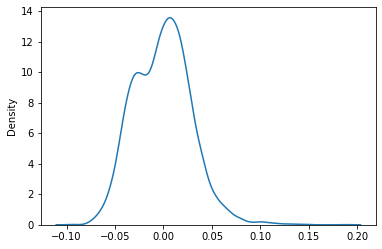

In [56]:
import seaborn as sns
cors_cor = list(map(lambda x: x[0], cors))
sns.kdeplot(np.array(list(cors_cor)))

In [57]:
np.median(np.array(list(cors_cor)))

-0.00042141969000515737

## Across pseudo-bulk cell aggregates by KNN

In [58]:
from scipy.stats import pearsonr
cors = []
for i in range(adata.layers['X_knn'].shape[1]):
    cors.append(pearsonr(adata.layers['X_knn'].toarray()[:, i],
                         adata.layers['gene_score_knn'].toarray()[:, i]))

<AxesSubplot:ylabel='Density'>

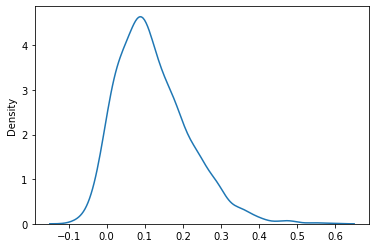

In [59]:
cors_cor = np.array(list(map(lambda x: x[0], cors)))
sns.kdeplot(cors_cor)

In [60]:
np.median(cors_cor[~np.isnan(cors_cor)])

0.10636744509305937

## Global correlation

In [61]:
def _global_pearson(x, y):
    numerator = np.mean((x - x.mean()) * (y - y.mean()))
    denominator = x.std() * y.std()
    if denominator == 0:
        return 0
    else:
        result = numerator / denominator
        return result

In [62]:
_global_pearson(adata.layers['X_knn'].toarray(),
                adata.layers['gene_score_knn'].toarray())

0.034380763793236103